In [3]:
import fastai.vision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from torchcontrol.arch_cpugpu import HDNN, HDNN_Observer
from torchcontrol.utils import genpoints
import matplotlib.pyplot as plt

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
PATH = 'E:\dataScience\data_sets\cifar-10-batches-py'

In [6]:
data1 = unpickle( f'{PATH}\data_batch_1')
data2 = unpickle( f'{PATH}\data_batch_2')
data3 = unpickle( f'{PATH}\data_batch_3')
data4 = unpickle( f'{PATH}\data_batch_4')
data5 = unpickle( f'{PATH}\data_batch_5')
test = unpickle( f'{PATH}\\test_batch')

In [7]:
im = np.reshape(data1[b'data'][2], (3, 32, 32))

In [8]:
im = np.swapaxes(im, 0, 2)

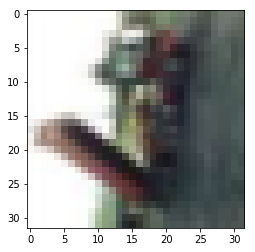

In [9]:
plt.imshow(im)

## cleaning up this uply dset

In [10]:
ds = []
dlabels = []
test_ds = []
test_dlabels = []

In [11]:
for i in range(10000):
    im = np.reshape(data1[b'data'][i],(3, 32, 32))
    ds.append(im)
    dlabels.append(data1[b'labels'][i])
for i in range(10000):
    im = np.reshape(data2[b'data'][i],(3, 32, 32))
    ds.append(im)
    dlabels.append(data2[b'labels'][i])
for i in range(10000):
    im = np.reshape(data3[b'data'][i],(3, 32, 32))
    ds.append(im)
    dlabels.append(data3[b'labels'][i])
for i in range(10000):
    im = np.reshape(data4[b'data'][i],(3, 32, 32))
    ds.append(im)
    dlabels.append(data4[b'labels'][i])
for i in range(10000):
    im = np.reshape(data5[b'data'][i],(3, 32, 32))
    ds.append(im)
    dlabels.append(data5[b'labels'][i])
for i in range(10000):
    im = np.reshape(test[b'data'][i],(3, 32, 32))
    test_ds.append(im)
    test_dlabels.append(test[b'labels'][i])

In [12]:
train = torch.utils.data.TensorDataset(torch.Tensor(ds), torch.LongTensor(dlabels))
test = torch.utils.data.TensorDataset(torch.Tensor(test_ds), torch.LongTensor(test_dlabels))

In [13]:
trainloader = torch.utils.data.DataLoader(train, batch_size = 24)
trainloader = torch.utils.data.DataLoader(test, batch_size = 24)

# HDNN vs CIFAR10

In [22]:
m = HDNN('VGG', ['VGG11'], [1,1,0], 1, p_module=__name__)

In [ ]:
m.fit(trainloader, epoch=1, time_delta=200, iter_accuracy=float('inf'), ode_t=5, ode_step=2, criterion='nll')

In [21]:

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           #nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [16]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                #nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.conv1(x))
        #out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        #self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        #out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x))
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])